In [19]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.data import Dataset
import db
import sys
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.python.keras.models import load_model
InteractiveShell.ast_node_interactivity = "all"

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
transferdb = myclient["transferdb"]

collfalse = transferdb["synfalse_transfers"]
colltrue = transferdb["true_transfers"]
df_false = pd.DataFrame(list(collfalse.find()))
df_true = pd.DataFrame(list(colltrue.find()))


# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [2]:
def preprocess_features(df):
    selected_features = df["tweet_text"].tolist()
    return selected_features

def preprocess_targets(df):
    output_targets = pd.DataFrame()
    output_targets["label_int"] = (df["label"] == "True").astype(float)
    return output_targets["label_int"].tolist()
    

    
    

In [3]:
# making the training sets
shuffeled_true = df_true.sample(frac=1)
shuffeled_false = df_false.sample(frac=1)
shuffeled = pd.concat([shuffeled_true, shuffeled_false]).sample(frac=1)
training_examples = preprocess_features(shuffeled.head(42000))
training_targets = preprocess_targets(shuffeled.head(42000))

validation_examples = preprocess_features(shuffeled.tail(6000))
validation_targets = preprocess_targets(shuffeled.tail(6000))




In [4]:
print("Training examples summary:")
display.display(training_examples)
print("Validation examples summary:")
display.display(validation_examples)

print("Training targets summary:")
display.display(training_targets)
print("Validation targets summary:")
display.display(validation_targets)

Training examples summary:


[u'Fulham beat Chelsea and Arsenal to signing of Nice star Jean-Michael Seri #Fulham #Chelsea #Arsenal #FPL #TransferNews #transferwindow',
 u'Manchester City are finalizing a deal to land Leicester City midfielder Riyad Mahrez for \xa367M and \xa3200K a week #ManCity #LeicesterCity #PL #FIFA #ASC',
 u'Rangers hope to push through deal for Joe Worrall in next 24 hours https:// trib.al/phJ7GnS',
 u'Manchester United biggest losers in Atletico transfer ban. Griezmann stays & they will sign players. Lacazette to Europa bound Arsenal #MUFC',
 u'Retweeted Sky Sports News ( @SkySportsNews ): BREAKING: James Maddison has decided to join Leicester City over Southampton and will undergo a medical with the Foxes today, according to Sky sources. #SSN pic.twitter.com/dORIGanjts',
 u'Transfer rumours: Suarez to Barcelona and Manchester United eye Hummels http:// owl.li/yhZT9',
 u'Daily Mail - Real Madrid to buy back Arsenal and Chelsea transfer target Alvaro Morata , confirm Juventus http:// dailym

Validation examples summary:


[u"Stoke City to Beat Swansea to Signing of Brentford 's Ryan Woods With Fee Agreed & Medical Set http:// dlvr.it/QgxLrs",
 u'* Celtic transfer news: Australia wonderkid Daniel Arzani to join Hoops on loan after penning permanent deal with Manchester City : Celtic are to sign Australia wonderkid Daniel Arzani on loan after the 19-year-old completes a permanent transfer to .. . http:// dld.bz/gUS3a',
 u"Transfer News: Arsenal's Benzema deal, Man Utd to sign De Gea, Chelsea in striker talks http:// shr.gs/8Y1lJiY",
 u"#Leeds United close in on deal for #Chelsea 's Lewis Baker | Yorkshire Evening Post https://www. football-addict.com/article/leeds- united-fc/yorkshireeveningpost/5b35ef53e0544734fb05d30b/leeds-united-close-in-on-deal-for-chelsea-s-lewis-baker?lang=en&utm_campaign=post-auto&utm_medium=twitter&utm_source=leeds-addict \u2026",
 u'Report: Jack Wilshere \u2019s free transfer to West Ham United in\xa0doubt https:// skysports.com.ng/2018/06/25/rep ort-jack-wilsheres-free-transfer

Training targets summary:


[1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0

Validation targets summary:


[1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0

In [5]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [6]:
ndarr = np.array(training_targets)


x_train, x_val = ngram_vectorize(training_examples, training_targets, validation_examples)
print(x_val)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


  (0, 1249)	0.10947514
  (0, 1268)	0.21478091
  (0, 2906)	0.2209675
  (0, 3501)	0.19898885
  (0, 3502)	0.2209675
  (0, 4312)	0.08128932
  (0, 5616)	0.08615361
  (0, 5617)	0.08615361
  (0, 6443)	0.11490903
  (0, 6445)	0.18895182
  (0, 8622)	0.044064872
  (0, 8647)	0.087775774
  (0, 9308)	0.07704838
  (0, 11354)	0.086682834
  (0, 11394)	0.21370676
  (0, 12665)	0.06517495
  (0, 12725)	0.2209675
  (0, 14873)	0.15722118
  (0, 14879)	0.20210873
  (0, 15265)	0.09372286
  (0, 15653)	0.07043959
  (0, 15747)	0.0999972
  (0, 16310)	0.1205514
  (0, 16313)	0.12897542
  (0, 16531)	0.14501074
  :	:
  (5999, 5617)	0.123779565
  (5999, 7537)	0.2776337
  (5999, 7539)	0.2885159
  (5999, 8622)	0.06330937
  (5999, 8647)	0.12611018
  (5999, 8972)	0.09520571
  (5999, 9058)	0.16373266
  (5999, 9308)	0.1106978
  (5999, 11525)	0.2026525
  (5999, 11538)	0.29440907
  (5999, 11655)	0.24719848
  (5999, 11660)	0.3292711
  (5999, 13638)	0.08653456
  (5999, 13640)	0.08654838
  (5999, 15017)	0.2885159
  (5999, 15018)	0

In [7]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [8]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [9]:
def plot_res(history):
    
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Training & Validation Accuracy")
    plt.tight_layout()
    plt.plot(history['acc'], label="training")
    plt.plot(history['val_acc'], label="validation")
    plt.legend()
    plt.show()
    
    

In [10]:
def plot_loss(history):
    plt.ylabel("Loss")
    plt.xlabel("Periods")
    plt.title("Training & Validation Loss")
    plt.tight_layout()
    plt.plot(history['loss'], label="training")
    plt.plot(history['val_loss'], label="validation")
    plt.legend()
    plt.show()
    

In [11]:
def roc_curve(history):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
        validation_targets[0:len(history["val_acc"])], history['val_acc'])
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)
    plt.show()

In [12]:
def calculate_auc(history):
    auc = metrics.roc_auc_score(validation_targets[0:len(history["val_acc"])], history['val_acc'])
    return auc
    

In [13]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=6,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    ndarr = np.array(train_labels)
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    plot_loss(history)
    auc_score = calculate_auc(history)
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1], auc_score

Train on 42000 samples, validate on 6000 samples
Epoch 1/20
 - 11s - loss: 0.4627 - acc: 0.8235 - val_loss: 0.1168 - val_acc: 0.9848
Epoch 2/20
 - 11s - loss: 0.1805 - acc: 0.9549 - val_loss: 0.0425 - val_acc: 0.9907
Epoch 3/20
 - 12s - loss: 0.1210 - acc: 0.9692 - val_loss: 0.0306 - val_acc: 0.9927
Epoch 4/20
 - 11s - loss: 0.1052 - acc: 0.9721 - val_loss: 0.0281 - val_acc: 0.9932
Epoch 5/20
 - 10s - loss: 0.0948 - acc: 0.9734 - val_loss: 0.0281 - val_acc: 0.9922
Epoch 6/20
 - 10s - loss: 0.0904 - acc: 0.9749 - val_loss: 0.0275 - val_acc: 0.9923
Epoch 7/20
 - 10s - loss: 0.0866 - acc: 0.9762 - val_loss: 0.0273 - val_acc: 0.9927
Epoch 8/20
 - 8s - loss: 0.0802 - acc: 0.9766 - val_loss: 0.0298 - val_acc: 0.9927
Epoch 9/20
 - 9s - loss: 0.0739 - acc: 0.9787 - val_loss: 0.0300 - val_acc: 0.9925
Epoch 10/20
 - 10s - loss: 0.0697 - acc: 0.9798 - val_loss: 0.0300 - val_acc: 0.9922
Epoch 11/20
 - 11s - loss: 0.0674 - acc: 0.9808 - val_loss: 0.0347 - val_acc: 0.9920
Epoch 12/20
 - 8s - loss: 0

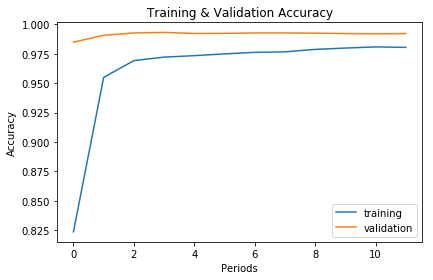

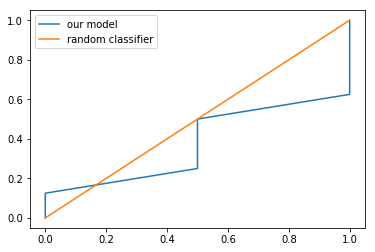

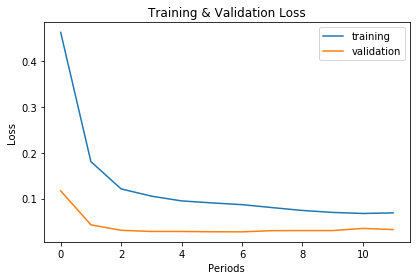

(0.99216664, 0.032251041245957214, 0.375)

In [15]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_ngram_model(data,
                      learning_rate=0.001,
                      epochs=20,
                      batch_size=128,
                      layers=4,
                      units=8,
                      dropout_rate=0.4)

In [62]:
def make_prediction(tweet_text):
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    print(tweet_text)
    x_train, x_val = ngram_vectorize(
        training_examples, training_targets, tweet_text)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.predict(x_val)
    print(prediction)

In [69]:
text = ["Arsenal transfer news and rumours: 'Gunners charter private jet to fly Karim Benzema to London for medical"]
make_prediction(text)



["Arsenal transfer news and rumours: 'Gunners charter private jet to fly Karim Benzema to London for medical"]
[[9.3195916e-07]]


In [98]:
# SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK 

In [82]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [83]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [90]:
def train_seq_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
        train_texts, val_texts)
    print(x_train.shape)
    print(x_val.shape)
    
    # Create model instance.
    model = sepcnn_model(blocks=2, filters=64, kernel_size=3, embedding_dim=200, dropout_rate=dropout_rate, pool_size=3, input_shape=x_train.shape[1:], 
                         num_classes=2, num_features=min(len(word_index) + 1, TOP_K))
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    auc_score = calculate_auc(history)
    
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1], auc

In [132]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_seq_model(data,
                      learning_rate=0.001,
                      epochs=100,
                      batch_size=128,
                      layers=6,
                      units=64,
                      dropout_rate=0.4)

(10000, 86)
(1000, 86)
Train on 10000 samples, validate on 1000 samples
Epoch 1/100
 - 18s - loss: 0.6913 - acc: 0.5351 - val_loss: 0.6907 - val_acc: 0.5360
Epoch 2/100
 - 14s - loss: 0.6907 - acc: 0.5349 - val_loss: 0.6906 - val_acc: 0.5360
Epoch 3/100


KeyboardInterrupt: 